<a href="https://colab.research.google.com/github/mnishio240/laserscar/blob/main/%E3%82%A2%E3%83%8E%E3%83%86%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3%E5%88%87%E3%82%8A%E6%8A%9C%E3%81%8D%E3%80%81%E3%82%AF%E3%83%AD%E3%83%83%E3%83%97%E4%BF%9D%E5%AD%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Identfy PC scar image from annotations**

In [ ]:
"""
PCAF_AI_Project

patient_dir = patient_dir = "/content/drive/MyDrive/Patient21R" (例)

pt1_2_0M_Photo.png --> 位置合わせをした眼底画像（2000 x 2000 px）

pt1_2_0M_Photo.txt
label cx cy wx wy track_number
0 0.724598 0.534400 0.010532 0.008982 158
0 0.720320 0.544252 0.010541 0.007405 159
0 0.722727 0.557084 0.012000 0.008595 160
0 0.709630 0.568616 0.012195 0.008414 161

このような感じでPCのアノーテーションが羅列されている。
YOLOのtrack形式。labelはすべて0で統一。
"""

'\nPCAF_AI_Project\n\npatient_dir = patient_dir = "/content/drive/MyDrive/Patient21R" (例)\n\npt1_2_0M_Photo.png --> 位置合わせをした眼底画像（2000 x 2000 px）\n\npt1_2_0M_Photo.txt\nlabel cx cy wx wy track_number\n0 0.724598 0.534400 0.010532 0.008982 158\n0 0.720320 0.544252 0.010541 0.007405 159\n0 0.722727 0.557084 0.012000 0.008595 160\n0 0.709630 0.568616 0.012195 0.008414 161\n\nこのような感じでPCのアノーテーションが羅列されている。\nYOLOのtrack形式。labelはすべて0で統一。\n'

In [ ]:
# prompt: gdriveに接続
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 対応したラベルのあるpngファイルをリスト化

In [ ]:
import os
import re

patient_dir = "/content/drive/MyDrive/Patient21R"

png_files = [f for f in os.listdir(patient_dir) if f.endswith('.png')]

# Extract numbers from filenames using regular expressions
png_files.sort(key=lambda var: [int(x) if x.isdigit() else x
                                   for x in re.findall(r'[^0-9]|[0-9]+', var)])

# Filter PNG files based on corresponding TXT files
filtered_png_files = [
    png_file for png_file in png_files
    if os.path.exists(os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt'))
]

print(filtered_png_files)

['Pt21R_2_0M_Photo.png', 'Pt21R_3_1M_AF.png', 'Pt21R_4_1M_Photo.png', 'Pt21R_5_1Y3M_AF.png', 'Pt21R_6_1Y3M_Photo.png']


処理対象のファイル:
Pt21R_2_0M_Photo.png
Pt21R_3_1M_AF.png
Pt21R_4_1M_Photo.png
Pt21R_5_1Y3M_AF.png
Pt21R_6_1Y3M_Photo.png


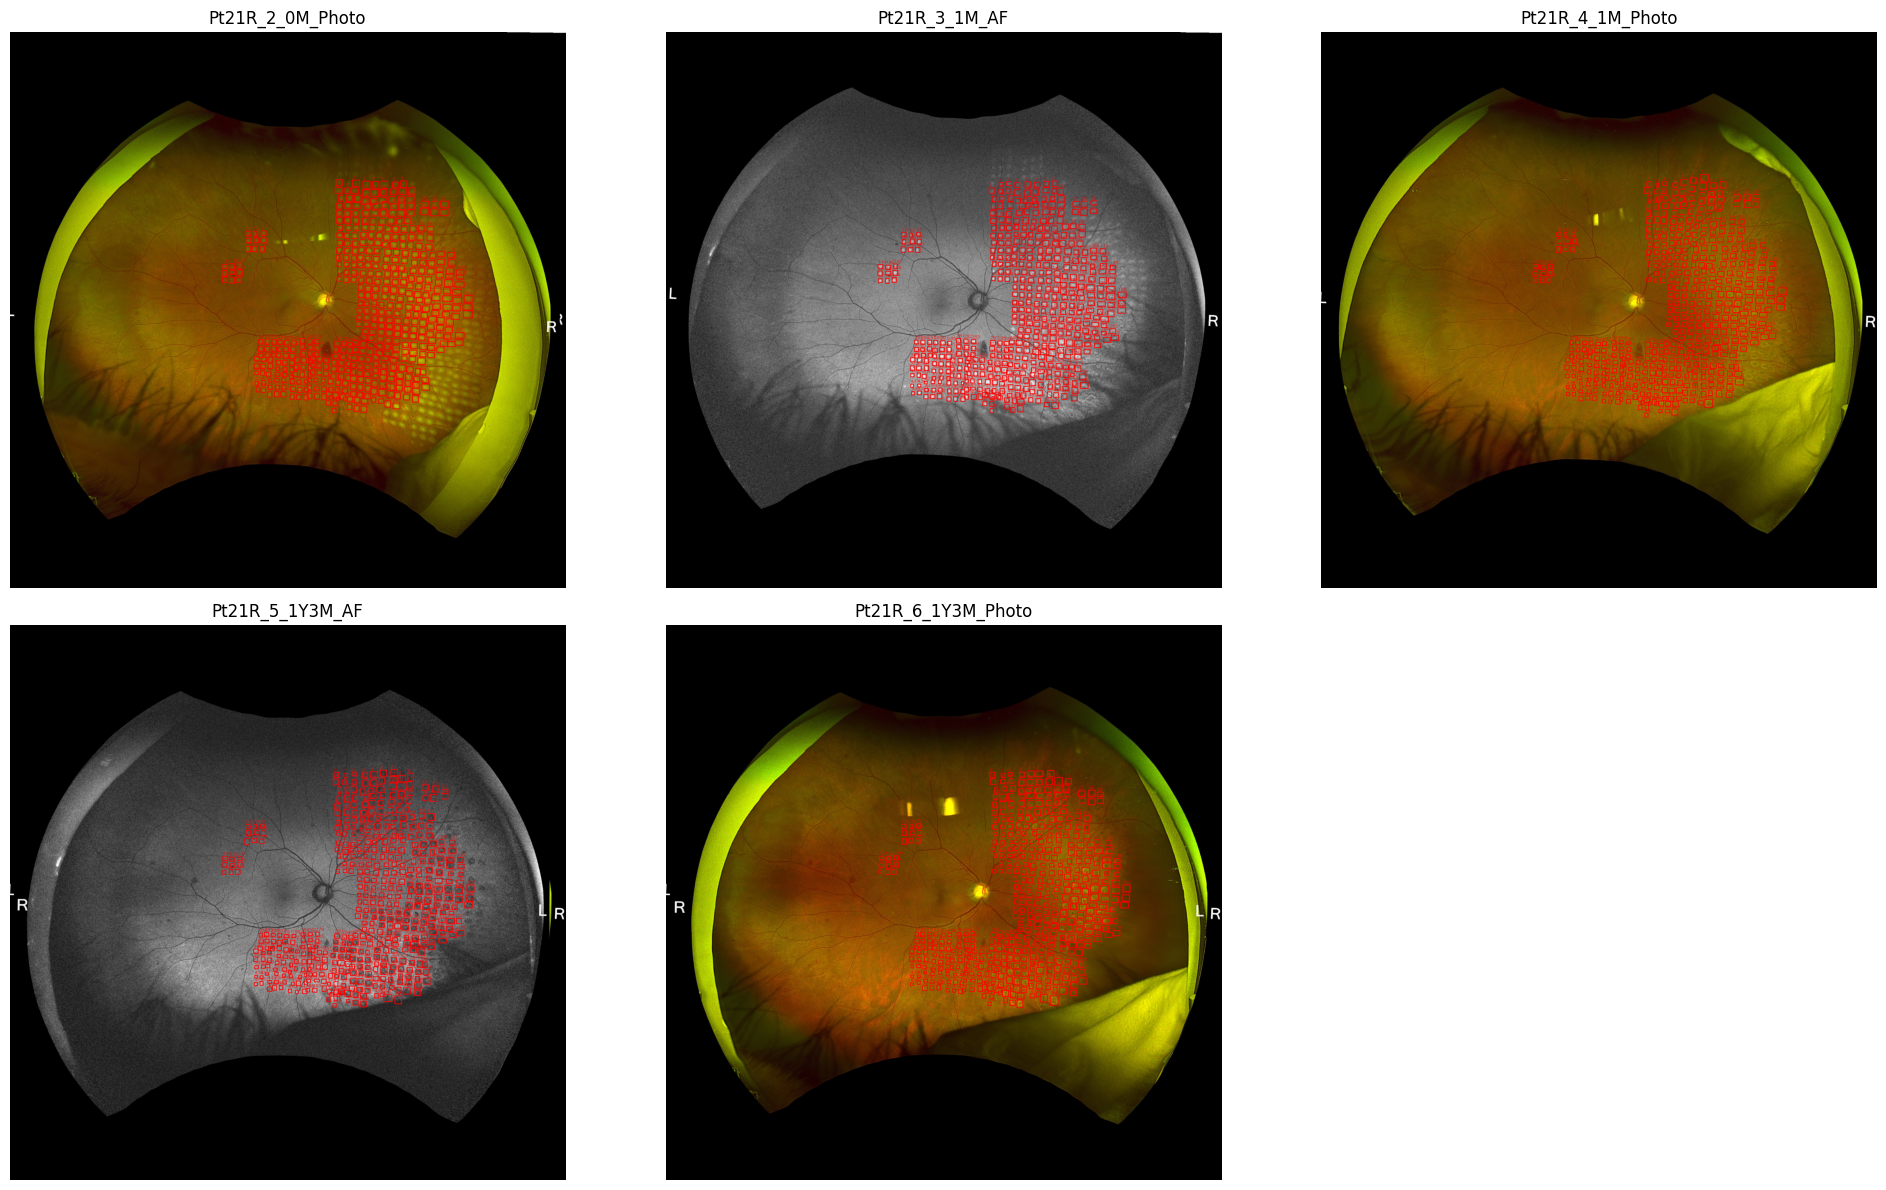

In [ ]:
# YOLOフォーマットのアノテーションを画像上に可視化するスクリプト
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from pathlib import Path

def get_filtered_png_files(patient_dir):
    """
    txtファイルが存在するpngファイルのみを取得し、ソートする
    """
    # PNGファイルを取得
    png_files = [f for f in os.listdir(patient_dir) if f.endswith('.png')]

    # ファイル名の数字でソート
    png_files.sort(key=lambda var: [int(x) if x.isdigit() else x
                                   for x in re.findall(r'[^0-9]|[0-9]+', var)])

    # 対応するTXTファイルが存在するPNGファイルのみをフィルタリング
    filtered_png_files = [
        png_file for png_file in png_files
        if os.path.exists(os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt'))
    ]

    return filtered_png_files

def visualize_annotations(patient_dir, png_files):
    """
    画像とそのアノテーションを可視化
    """
    n_images = len(png_files)
    n_cols = 3  # 1行あたりの画像数
    n_rows = (n_images + n_cols - 1) // n_cols  # 切り上げ除算

    plt.figure(figsize=(20, 6*n_rows))

    for idx, png_file in enumerate(png_files, 1):
        # 画像の読み込み
        img_path = os.path.join(patient_dir, png_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # アノテーションファイルの読み込み
        txt_path = os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt')
        columns = ['label', 'cx', 'cy', 'wx', 'wy', 'track_number']
        df = pd.read_csv(txt_path, sep=' ', names=columns, skiprows=1)  # ヘッダーをスキップ

        # 画像サイズの取得
        height, width = img.shape[:2]

        # バウンディングボックスの描画
        for _, row in df.iterrows():
            # 相対座標を絶対座標に変換
            x_center = int(row['cx'] * width)
            y_center = int(row['cy'] * height)
            box_width = int(row['wx'] * width)
            box_height = int(row['wy'] * height)

            # バウンディングボックスの左上と右下の座標を計算
            x1 = int(x_center - box_width/2)
            y1 = int(y_center - box_height/2)
            x2 = int(x_center + box_width/2)
            y2 = int(y_center + box_height/2)

            # バウンディングボックスを描画
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # トラッキング番号を表示
            cv2.putText(img, str(int(row['track_number'])),
                       (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,
                       0.5, (255, 0, 0), 1)

        # サブプロットに表示
        plt.subplot(n_rows, n_cols, idx)
        plt.imshow(img)
        plt.title(f'{os.path.splitext(png_file)[0]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # ディレクトリパスの設定
    patient_dir = "/content/drive/MyDrive/Patient21R"

    # 対象となるPNGファイルを取得
    filtered_png_files = get_filtered_png_files(patient_dir)

    print("処理対象のファイル:")
    for f in filtered_png_files:
        print(f)

    # バウンディングボックスの可視化
    visualize_annotations(patient_dir, filtered_png_files)

### ラベルの整理

In [ ]:
# テキストファイル内の各行の先頭の数字（ラベル）を0に変更するスクリプト
# 対象ファイル形式：スペース区切りのテキストファイル
# 入力例：
# label cx cy wx wy track_number
# 1 0.619445 0.563755 0.008109 0.008600 150
# 出力例：
# 0 0.619445 0.563755 0.008109 0.008600 150

import os
from tqdm import tqdm

patient_dir = "/content/drive/MyDrive/Patient21R"

# すべてのtxtファイルを取得
txt_files = [f for f in os.listdir(patient_dir) if f.endswith('.txt')]

# tqdmで進捗バーを表示
for txt_file in tqdm(txt_files, desc="ファイル処理中"):
    file_path = os.path.join(patient_dir, txt_file)

    # ファイルの内容を読み込む
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # 各行の最初の数字を0に変更
    modified_lines = []
    for line in lines:
        parts = line.split()
        if parts:  # 空行でないことを確認
            parts[0] = '0'  # 最初の数字を0に変更
            modified_lines.append(' '.join(parts) + '\n')

    # 変更した内容を書き込む
    with open(file_path, 'w') as file:
        file.writelines(modified_lines)

print("\nすべてのファイルの処理が完了しました。")

ファイル処理中: 100%|██████████| 5/5 [00:00<00:00, 53.48it/s]


すべてのファイルの処理が完了しました。


In [ ]:
# 概要：
# 1. 全てのテキストファイルを走査し、トラッキング番号の出現状況を調べる
# 2. 一部のファイルにしか出現しないトラッキング番号を検出
# 3. 検出結果を表示し、ユーザーに削除の確認を取る
# 4. 確認が取れたら、該当するトラッキング番号を含む行を全ファイルから削除
#
# 入力例：
# label cx cy wx wy track_number
# 1 0.619445 0.563755 0.008109 0.008600 150
#
# 処理内容：
# - 全txtファイルの6列目(track_number)を確認
# - 全ファイルに出現しないtrack_numberを検出
# - 検出されたtrack_numberを含む行を各ファイルから削除
# - 進捗状況をtqdmで表示
# - ユーザー確認機能あり

import os
from collections import defaultdict
from tqdm import tqdm

def find_incomplete_tracking_numbers(patient_dir):
    tracking_presence = defaultdict(set)
    txt_files = [f for f in os.listdir(patient_dir) if f.endswith('.txt')]
    total_files = len(txt_files)

    print(f"全ファイル数: {total_files}")

    # 各ファイルでのトラッキング番号の出現を記録
    for txt_file in txt_files:
        file_path = os.path.join(patient_dir, txt_file)
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) >= 6:
                    try:
                        track_number = int(parts[5])
                        tracking_presence[track_number].add(txt_file)
                    except (ValueError, IndexError):
                        continue

    # 全ファイルに出現していないトラッキング番号を抽出
    incomplete_tracking = {
        track_num: files
        for track_num, files in tracking_presence.items()
        if len(files) < total_files
    }

    return incomplete_tracking, txt_files

def display_incomplete_tracks(incomplete_tracking, total_files):
    print(f"\n全ファイルに出現していないトラッキング番号の数: {len(incomplete_tracking)}")

    # 詳細情報の表示
    print("\n===== 最初の10個の例 =====")
    for track_num, files in list(incomplete_tracking.items())[:10]:
        print(f"\nトラッキング番号: {track_num}")
        print(f"出現ファイル数: {len(files)} / {total_files}")
        print(f"出現率: {(len(files)/total_files)*100:.1f}%")

def remove_incomplete_tracks(patient_dir, incomplete_tracking_nums):
    txt_files = [f for f in os.listdir(patient_dir) if f.endswith('.txt')]

    for txt_file in tqdm(txt_files, desc="ファイル処理中"):
        file_path = os.path.join(patient_dir, txt_file)

        with open(file_path, 'r') as file:
            lines = file.readlines()

        new_lines = []
        removed_count = 0
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 6:
                try:
                    track_number = int(parts[5])
                    if track_number not in incomplete_tracking_nums:
                        new_lines.append(line)
                    else:
                        removed_count += 1
                except (ValueError, IndexError):
                    new_lines.append(line)
            else:
                new_lines.append(line)

        with open(file_path, 'w') as file:
            file.writelines(new_lines)

    return removed_count

def main():
    patient_dir = "/content/drive/MyDrive/Patient21R"

    print("不完全なトラッキング番号を検出中...\n")
    incomplete_tracking, txt_files = find_incomplete_tracking_numbers(patient_dir)

    # 検出結果の表示
    display_incomplete_tracks(incomplete_tracking, len(txt_files))

    # ユーザーに確認
    while True:
        response = input("\nこれらのトラッキング番号を含む行を削除しますか？ (yes/no): ").lower()
        if response in ['yes', 'no']:
            break
        print("'yes' または 'no' で入力してください。")

    if response == 'yes':
        print("\n削除を実行します...")
        incomplete_tracking_nums = set(incomplete_tracking.keys())
        total_removed = remove_incomplete_tracks(patient_dir, incomplete_tracking_nums)
        print(f"\n処理が完了しました。")
        print(f"削除された行の総数: {total_removed}")
    else:
        print("\n処理を中止しました。")

if __name__ == "__main__":
    main()

不完全なトラッキング番号を検出中...

全ファイル数: 5

全ファイルに出現していないトラッキング番号の数: 0

===== 最初の10個の例 =====

これらのトラッキング番号を含む行を削除しますか？ (yes/no): yes

削除を実行します...


ファイル処理中: 100%|██████████| 5/5 [00:00<00:00, 73.80it/s]


処理が完了しました。
削除された行の総数: 0


#**Analyze PC scar size**

<ipython-input-16-61070b1910e5>:62: UserWarning: Glyph 20957 (\N{CJK UNIFIED IDEOGRAPH-51DD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:62: UserWarning: Glyph 22266 (\N{CJK UNIFIED IDEOGRAPH-56FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:62: UserWarning: Glyph 26001 (\N{CJK UNIFIED IDEOGRAPH-6591}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:62: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:62: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:62: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:62: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from

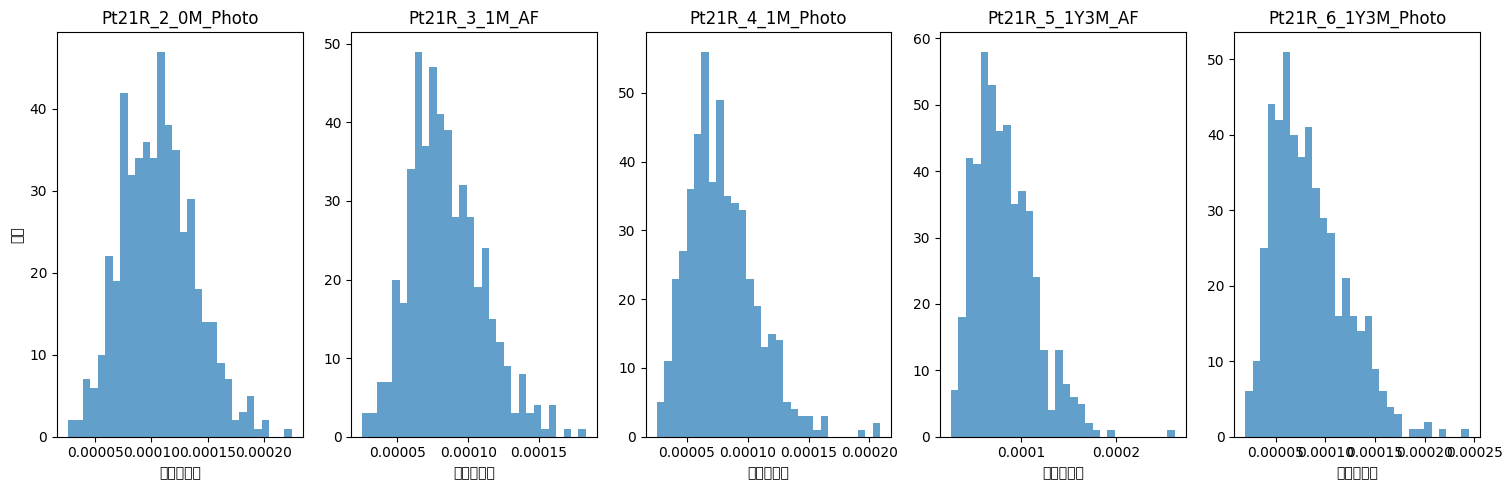

<ipython-input-16-61070b1910e5>:73: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:73: UserWarning: Glyph 12449 (\N{KATAKANA LETTER SMALL A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:73: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:73: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:73: UserWarning: Glyph 21517 (\N{CJK UNIFIED IDEOGRAPH-540D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:73: UserWarning: Glyph 20957 (\N{CJK UNIFIED IDEOGRAPH-51DD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-61070b1910e5>:73: UserWarning: Glyph 22266 (\N{CJK UNIFIED IDEOGRAPH-56FA}) missing from font(s) DejaVu Sans.
  plt.

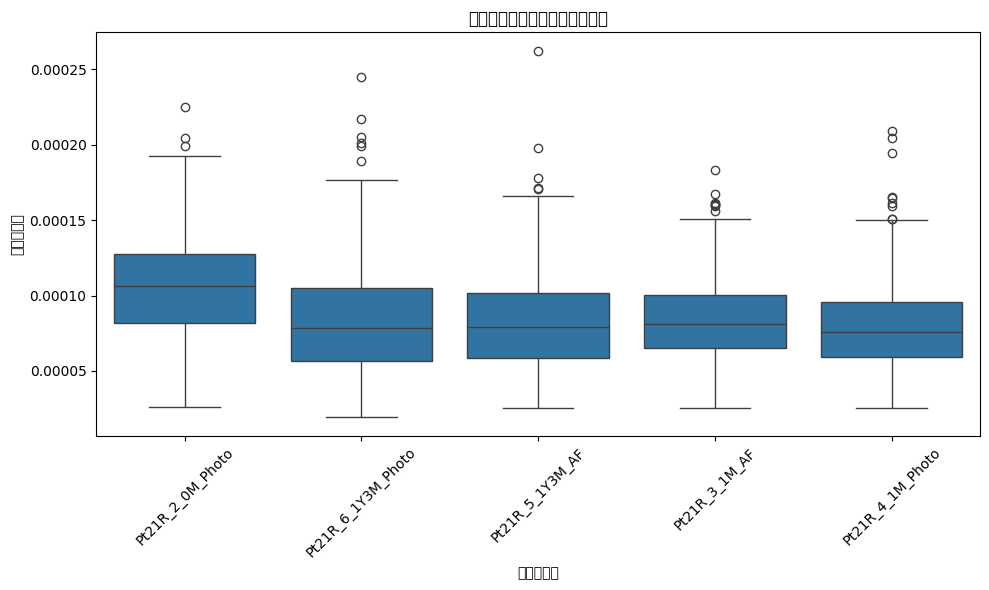


各ファイルの統計情報:
                    count      mean       std       min       25%       50%  \
file                                                                          
Pt21R_2_0M_Photo    496.0  0.000106  0.000032  0.000026  0.000082  0.000106   
Pt21R_3_1M_AF       496.0  0.000085  0.000026  0.000025  0.000066  0.000081   
Pt21R_4_1M_Photo    496.0  0.000079  0.000028  0.000025  0.000059  0.000076   
Pt21R_5_1Y3M_AF     496.0  0.000082  0.000032  0.000025  0.000059  0.000079   
Pt21R_6_1Y3M_Photo  496.0  0.000084  0.000036  0.000019  0.000056  0.000078   

                         75%       max  
file                                    
Pt21R_2_0M_Photo    0.000128  0.000225  
Pt21R_3_1M_AF       0.000100  0.000183  
Pt21R_4_1M_Photo    0.000096  0.000209  
Pt21R_5_1Y3M_AF     0.000102  0.000262  
Pt21R_6_1Y3M_Photo  0.000105  0.000245  


In [ ]:
# 凝固斑サイズの分布を可視化するスクリプト
#
# 機能:
# - 指定ディレクトリ内の全txtファイルを読み込み
# - 各凝固斑のサイズ(wx * wy)を計算
# - ヒストグラムと箱ひげ図で分布を可視化
# - 基本統計量を計算して表示
#
# 入力ファイル形式：
# label cx cy wx wy track_number
# 1 0.619445 0.563755 0.008109 0.008600 150

import pandas as pd
import matplotlib.pyplot as plt
#import japanize_matplotlib
import numpy as np
from pathlib import Path
import seaborn as sns
import glob
import os

def analyze_size_distribution(patient_dir):
    """
    ディレクトリ内の全txtファイルの凝固斑サイズ分布を分析
    """
    # txtファイルを検索
    txt_files = glob.glob(os.path.join(patient_dir, '*.txt'))
    if not txt_files:
        print(f"警告: {patient_dir} 内にtxtファイルが見つかりませんでした。")
        return None

    # 全ファイルのデータを読み込み
    all_data = []
    for txt_path in txt_files:
        # データの読み込み
        columns = ['label', 'cx', 'cy', 'wx', 'wy', 'track_number']
        df = pd.read_csv(txt_path, sep=' ', names=columns)

        # バウンディングボックスの面積を計算
        df['area'] = df['wx'] * df['wy']
        # ファイル名を追加
        df['file'] = Path(txt_path).stem
        all_data.append(df)

    # 全データを結合
    combined_df = pd.concat(all_data, ignore_index=True)

    # 1. ヒストグラムの作成（ファイル毎に並べて表示）
    plt.figure(figsize=(15, 5))
    unique_files = sorted(combined_df['file'].unique())
    n_files = len(unique_files)

    for i, file in enumerate(unique_files, 1):
        plt.subplot(1, n_files, i)
        file_data = combined_df[combined_df['file'] == file]
        plt.hist(file_data['area'], bins=30, alpha=0.7)
        plt.title(f'{file}')
        plt.xlabel('凝固斑面積')
        if i == 1:
            plt.ylabel('頻度')

    plt.tight_layout()
    plt.show()

    # 2. 箱ひげ図の作成
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='file', y='area', data=combined_df)
    plt.title('ファイル毎の凝固斑サイズ分布')
    plt.xlabel('ファイル名')
    plt.ylabel('凝固斑面積')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # 基本統計量の計算
    stats = combined_df.groupby('file')['area'].describe()
    print("\n各ファイルの統計情報:")
    print(stats)

    return stats

if __name__ == "__main__":
    patient_dir = "/content/drive/MyDrive/Patient21R"
    stats = analyze_size_distribution(patient_dir)


検出されたファイル:
Pt21R_2_0M_Photo
Pt21R_6_1Y3M_Photo
Pt21R_5_1Y3M_AF
Pt21R_3_1M_AF
Pt21R_4_1M_Photo

実際のファイル一覧:
['Pt21R_2_0M_Photo', 'Pt21R_3_1M_AF', 'Pt21R_4_1M_Photo', 'Pt21R_5_1Y3M_AF', 'Pt21R_6_1Y3M_Photo']


<ipython-input-17-27b5e7d1ac2c>:61: UserWarning: Glyph 20957 (\N{CJK UNIFIED IDEOGRAPH-51DD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:61: UserWarning: Glyph 22266 (\N{CJK UNIFIED IDEOGRAPH-56FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:61: UserWarning: Glyph 26001 (\N{CJK UNIFIED IDEOGRAPH-6591}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:61: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:61: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:61: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:61: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from

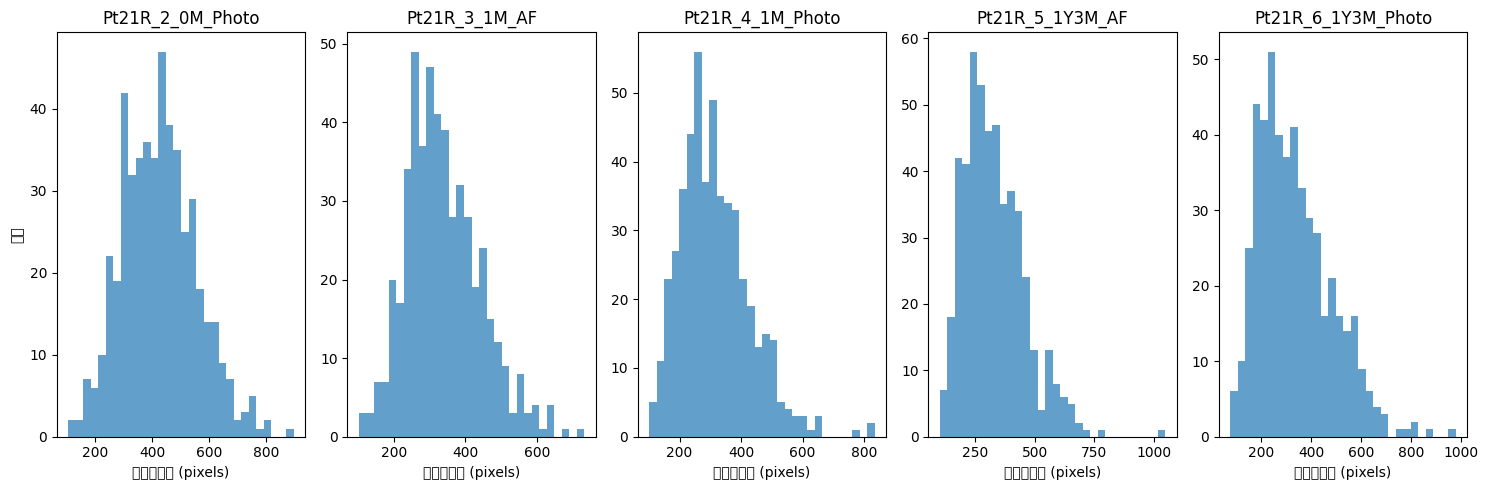

<ipython-input-17-27b5e7d1ac2c>:72: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:72: UserWarning: Glyph 12449 (\N{KATAKANA LETTER SMALL A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:72: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:72: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:72: UserWarning: Glyph 21517 (\N{CJK UNIFIED IDEOGRAPH-540D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:72: UserWarning: Glyph 20957 (\N{CJK UNIFIED IDEOGRAPH-51DD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-27b5e7d1ac2c>:72: UserWarning: Glyph 22266 (\N{CJK UNIFIED IDEOGRAPH-56FA}) missing from font(s) DejaVu Sans.
  plt.

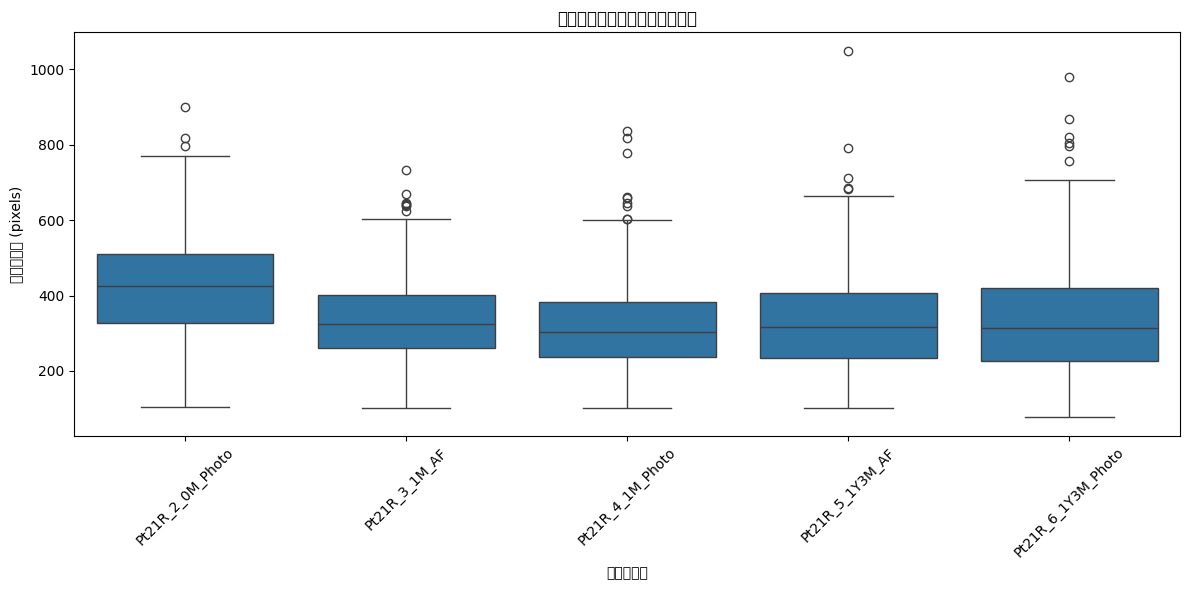


各ファイルの統計情報 (ピクセル単位):
                    count        mean         std       min         25%  \
file                                                                      
Pt21R_2_0M_Photo    496.0  425.580318  129.522958  103.9775  327.372450   
Pt21R_3_1M_AF       496.0  338.150859  103.163110  101.1388  262.089700   
Pt21R_4_1M_Photo    496.0  315.952098  112.741231  101.1388  236.068550   
Pt21R_5_1Y3M_AF     496.0  329.795984  127.251740  101.1388  235.248075   
Pt21R_6_1Y3M_Photo  496.0  335.799376  145.199635   77.0875  225.534675   

                          50%         75%        max  
file                                                  
Pt21R_2_0M_Photo    425.15795  510.312675   898.8936  
Pt21R_3_1M_AF       324.96310  400.289325   732.5648  
Pt21R_4_1M_Photo    303.10150  382.194425   835.4120  
Pt21R_5_1Y3M_AF     315.63280  406.491000  1049.5920  
Pt21R_6_1Y3M_Photo  312.90455  421.287000   978.4620  


In [ ]:
# 凝固斑サイズの分布を可視化するスクリプト（ピクセル数換算版）

import pandas as pd
import matplotlib.pyplot as plt
#import japanize_matplotlib
import numpy as np
from pathlib import Path
import seaborn as sns
import glob
import os

def analyze_size_distribution(patient_dir):
    """
    ディレクトリ内の全txtファイルの凝固斑サイズ分布を分析
    """
    # txtファイルを検索
    txt_files = glob.glob(os.path.join(patient_dir, '*.txt'))
    if not txt_files:
        print(f"警告: {patient_dir} 内にtxtファイルが見つかりませんでした。")
        return None

    # 実際のファイル名を確認
    print("検出されたファイル:")
    for f in txt_files:
        print(Path(f).stem)

    # 全ファイルのデータを読み込み
    all_data = []
    for txt_path in txt_files:
        # データの読み込み
        columns = ['label', 'cx', 'cy', 'wx', 'wy', 'track_number']
        df = pd.read_csv(txt_path, sep=' ', names=columns)

        # バウンディングボックスの面積をピクセル数に換算
        df['area_pixels'] = df['wx'] * df['wy'] * 2000 * 2000
        # ファイル名を追加
        df['file'] = Path(txt_path).stem
        all_data.append(df)

    # 全データを結合
    combined_df = pd.concat(all_data, ignore_index=True)

    # 実際に存在するファイルの一覧を取得
    existing_files = sorted(combined_df['file'].unique())
    print("\n実際のファイル一覧:")
    print(existing_files)

    # 1. ヒストグラムの作成（ファイル毎に並べて表示）
    plt.figure(figsize=(15, 5))
    n_files = len(existing_files)

    for i, file in enumerate(existing_files, 1):
        plt.subplot(1, n_files, i)
        file_data = combined_df[combined_df['file'] == file]
        plt.hist(file_data['area_pixels'], bins=30, alpha=0.7)
        plt.title(f'{file}')
        plt.xlabel('凝固斑面積 (pixels)')
        if i == 1:
            plt.ylabel('頻度')

    plt.tight_layout()
    plt.show()

    # 2. 箱ひげ図の作成
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='file', y='area_pixels', data=combined_df, order=existing_files)
    plt.title('ファイル毎の凝固斑サイズ分布')
    plt.xlabel('ファイル名')
    plt.ylabel('凝固斑面積 (pixels)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # 基本統計量の計算
    stats = combined_df.groupby('file')['area_pixels'].describe()
    print("\n各ファイルの統計情報 (ピクセル単位):")
    print(stats)

    return stats

if __name__ == "__main__":
    patient_dir = "/content/drive/MyDrive/Patient21R"
    stats = analyze_size_distribution(patient_dir)

In [ ]:
import os
import re

patient_dir = "/content/drive/MyDrive/Patient21R"

# ディレクトリの中身を確認
try:
    all_files = os.listdir(patient_dir)
    print("ディレクトリの中身:", all_files)
except Exception as e:
    print("エラー:", e)
    exit()

# PNGファイルを取得（大文字・小文字両方考慮）
png_files = [f for f in all_files if f.lower().endswith('.png')]
print("PNGファイル:", png_files)

# ソートの確認
try:
    png_files.sort(key=lambda var: [int(x) if x.isdigit() else x for x in re.findall(r'\d+|\D+', var)])
    print("ソート後:", png_files)
except Exception as e:
    print("ソートエラー:", e)

# TXTファイルがあるかチェック
filtered_png_files = []
for png_file in png_files:
    txt_file_path = os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt')
    if os.path.exists(txt_file_path):
        filtered_png_files.append(png_file)
    else:
        print(f"対応するTXTファイルが見つからない: {txt_file_path}")

print("フィルタリング後のPNGファイル:", filtered_png_files)


ディレクトリの中身: ['Pt21R_2_0M_Photo.txt', 'Pt21R_6_1Y3M_Photo.txt', 'Pt21R_5_1Y3M_AF.txt', 'Pt21R_3_1M_AF.txt', 'Pt21R_4_1M_Photo.txt', 'patch_img', 'Pt21R_0_pre_AF.png', 'Pt21R_2_0M_Photo.png', 'Pt21R_1_pre_Photo.png', 'Pt21R_5_1Y3M_AF.png', 'Pt21R_4_1M_Photo.png', 'Pt21R_3_1M_AF.png', 'Pt21R_6_1Y3M_Photo.png']
PNGファイル: ['Pt21R_0_pre_AF.png', 'Pt21R_2_0M_Photo.png', 'Pt21R_1_pre_Photo.png', 'Pt21R_5_1Y3M_AF.png', 'Pt21R_4_1M_Photo.png', 'Pt21R_3_1M_AF.png', 'Pt21R_6_1Y3M_Photo.png']
ソート後: ['Pt21R_0_pre_AF.png', 'Pt21R_1_pre_Photo.png', 'Pt21R_2_0M_Photo.png', 'Pt21R_3_1M_AF.png', 'Pt21R_4_1M_Photo.png', 'Pt21R_5_1Y3M_AF.png', 'Pt21R_6_1Y3M_Photo.png']
対応するTXTファイルが見つからない: /content/drive/MyDrive/Patient21R/Pt21R_0_pre_AF.txt
対応するTXTファイルが見つからない: /content/drive/MyDrive/Patient21R/Pt21R_1_pre_Photo.txt
フィルタリング後のPNGファイル: ['Pt21R_2_0M_Photo.png', 'Pt21R_3_1M_AF.png', 'Pt21R_4_1M_Photo.png', 'Pt21R_5_1Y3M_AF.png', 'Pt21R_6_1Y3M_Photo.png']


In [ ]:
import cv2
import pandas as pd
import os
import re

def get_filtered_png_files(patient_dir):
    """
    txtファイルが存在するpngファイルのみを取得し、ソートする
    """
    png_files = [f for f in os.listdir(patient_dir) if f.endswith('.png')]
    png_files.sort(key=lambda var: [int(x) if x.isdigit() else x
                                   for x in re.findall(r'[^0-9]|[0-9]+', var)])
    filtered_png_files = [
        png_file for png_file in png_files
        if os.path.exists(os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt'))
    ]
    return filtered_png_files

def save_cropped_annotations(patient_dir, output_dir):
    """
    各トラック番号ごとにバウンディングボックスを切り抜き、保存
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # PNGファイルを取得
    png_files = get_filtered_png_files(patient_dir)

    for png_file in png_files:
        img_path = os.path.join(patient_dir, png_file)
        img = cv2.imread(img_path)

        txt_path = os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt')
        columns = ['label', 'cx', 'cy', 'wx', 'wy', 'track_number']
        df = pd.read_csv(txt_path, sep=' ', names=columns, skiprows=1)

        height, width = img.shape[:2]

        for _, row in df.iterrows():
            # バウンディングボックスの座標計算
            x_center = int(row['cx'] * width)
            y_center = int(row['cy'] * height)
            box_width = int(row['wx'] * width)
            box_height = int(row['wy'] * height)

            x1 = max(0, int(x_center - box_width / 2))
            y1 = max(0, int(y_center - box_height / 2))
            x2 = min(width, int(x_center + box_width / 2))
            y2 = min(height, int(y_center + box_height / 2))

            # バウンディングボックスを切り抜き
            cropped_img = img[y1:y2, x1:x2]

            # ファイル名を生成
            track_number = int(row['track_number'])
            label = int(row['label'])
            cropped_filename = f"{os.path.splitext(png_file)[0]}_label{label}_track{track_number}.png"

            # 保存先パス
            save_path = os.path.join(output_dir, cropped_filename)
            cv2.imwrite(save_path, cropped_img)

            print(f"Saved: {save_path}")

if __name__ == "__main__":
    # 元画像とアノテーションファイルのディレクトリ
    patient_dir = "import cv2
import pandas as pd
import os
import re

def get_filtered_png_files(patient_dir):
    """
    txtファイルが存在するpngファイルのみを取得し、ソートする
    """
    png_files = [f for f in os.listdir(patient_dir) if f.endswith('.png')]
    png_files.sort(key=lambda var: [int(x) if x.isdigit() else x
                                   for x in re.findall(r'[^0-9]|[0-9]+', var)])
    filtered_png_files = [
        png_file for png_file in png_files
        if os.path.exists(os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt'))
    ]
    return filtered_png_files

def save_cropped_annotations(patient_dir, output_dir):
    """
    各トラック番号ごとにバウンディングボックスを切り抜き、保存
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # PNGファイルを取得
    png_files = get_filtered_png_files(patient_dir)

    for png_file in png_files:
        img_path = os.path.join(patient_dir, png_file)
        img = cv2.imread(img_path)

        txt_path = os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt')
        columns = ['label', 'cx', 'cy', 'wx', 'wy', 'track_number']
        df = pd.read_csv(txt_path, sep=' ', names=columns, skiprows=1)

        height, width = img.shape[:2]

        for _, row in df.iterrows():
            # バウンディングボックスの座標計算
            x_center = int(row['cx'] * width)
            y_center = int(row['cy'] * height)
            box_width = int(row['wx'] * width)
            box_height = int(row['wy'] * height)

            x1 = max(0, int(x_center - box_width / 2))
            y1 = max(0, int(y_center - box_height / 2))
            x2 = min(width, int(x_center + box_width / 2))
            y2 = min(height, int(y_center + box_height / 2))

            # バウンディングボックスを切り抜き
            cropped_img = img[y1:y2, x1:x2]

            # ファイル名を生成
            track_number = int(row['track_number'])
            label = int(row['label'])
            cropped_filename = f"{os.path.splitext(png_file)[0]}_label{label}_track{track_number}.png"

            # 保存先パス
            save_path = os.path.join(output_dir, cropped_filename)
            cv2.imwrite(save_path, cropped_img)

            print(f"Saved: {save_path}")

if __name__ == "__main__":
    # 元画像とアノテーションファイルのディレクトリ
    patient_dir = "/content/drive/MyDrive/Patient21R"
    # 切り抜き画像の保存先
    output_dir = "/content/drive/MyDrive/Patient21R_Cropped"

    save_cropped_annotations(patient_dir, output_dir)
"
    # 切り抜き画像の保存先
    output_dir = "/content/drive/MyDrive/Patient21R_Cropped"

    save_cropped_annotations(patient_dir, output_dir)


SyntaxError: unterminated string literal (detected at line 67) (<ipython-input-19-d7b7323603b9>, line 67)

In [ ]:
import cv2
import pandas as pd
import os
import re

def get_filtered_png_files(patient_dir):
    """
    txtファイルが存在するpngファイルのみを取得し、ソートする
    """
    png_files = [f for f in os.listdir(patient_dir) if f.endswith('.png')]
    png_files.sort(key=lambda var: [int(x) if x.isdigit() else x
                                   for x in re.findall(r'[^0-9]|[0-9]+', var)])
    filtered_png_files = [
        png_file for png_file in png_files
        if os.path.exists(os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt'))
    ]
    return filtered_png_files

def save_cropped_annotations(patient_dir, output_dir):
    """
    各トラック番号ごとにバウンディングボックスを切り抜き、保存
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # PNGファイルを取得
    png_files = get_filtered_png_files(patient_dir)

    if not png_files:
        print(f"❌ PNGファイルが見つかりません: {patient_dir}")
        return

    for png_file in png_files:
        img_path = os.path.join(patient_dir, png_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ 画像が読み込めません: {img_path}")
            continue

        txt_path = os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt')
        columns = ['label', 'cx', 'cy', 'wx', 'wy', 'track_number']

        try:
            df = pd.read_csv(txt_path, sep=' ', names=columns, skiprows=1)
        except Exception as e:
            print(f"❌ アノテーションファイルの読み込みエラー: {txt_path} -> {e}")
            continue

        height, width = img.shape[:2]

        for _, row in df.iterrows():
            try:
                # バウンディングボックスの座標計算
                x_center = int(row['cx'] * width)
                y_center = int(row['cy'] * height)
                box_width = int(row['wx'] * width)
                box_height = int(row['wy'] * height)

                x1 = max(0, int(x_center - box_width / 2))
                y1 = max(0, int(y_center - box_height / 2))
                x2 = min(width, int(x_center + box_width / 2))
                y2 = min(height, int(y_center + box_height / 2))

                # バウンディングボックスを切り抜き
                cropped_img = img[y1:y2, x1:x2]

                if cropped_img.size == 0:
                    print(f"⚠️ 切り抜き領域が無効: {png_file}, Track: {int(row['track_number'])}")
                    continue

                # ファイル名を生成
                track_number = int(row['track_number'])
                label = int(row['label'])
                cropped_filename = f"{os.path.splitext(png_file)[0]}_label{label}_track{track_number}.png"

                # 保存先パス
                save_path = os.path.join(output_dir, cropped_filename)
                cv2.imwrite(save_path, cropped_img)

                print(f"✅ Saved: {save_path}")

            except Exception as e:
                print(f"❌ エラー発生: {png_file} -> {e}")

if __name__ == "__main__":
    # 元画像とアノテーションファイルのディレクトリ
    patient_dir = "/content/drive/MyDrive/Patient21R"
    # 切り抜き画像の保存先
    output_dir = "/content/drive/MyDrive/Patient21R_Cropped"

    save_cropped_annotations(patient_dir, output_dir)


✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/Pt21R_2_0M_Photo_label0_track1.png
✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/Pt21R_2_0M_Photo_label0_track2.png
✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/Pt21R_2_0M_Photo_label0_track3.png
✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/Pt21R_2_0M_Photo_label0_track4.png
✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/Pt21R_2_0M_Photo_label0_track5.png
✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/Pt21R_2_0M_Photo_label0_track6.png
✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/Pt21R_2_0M_Photo_label0_track7.png
✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/Pt21R_2_0M_Photo_label0_track8.png
✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/Pt21R_2_0M_Photo_label0_track9.png
✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/Pt21R_2_0M_Photo_label0_track10.png
✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/Pt21R_2_0M_Photo_label0_track11.png
✅ Saved: /content/drive/MyDrive/Patient21R_Cropped/P